In [6]:
import pandas as pd
import os,sys, imp, glob
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import feature_utils, common_utils
import defines
import numpy as np
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut,GroupKFold

from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import random
import model_utils
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import Counter
import scipy
import nltk

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.pipeline import Pipeline


In [2]:
dir_name="reparse"

In [3]:
db_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name)
db_path

'/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse'

In [ ]:
glob.glob(os.path.join(db_path,"*sc*merged*"))

In [17]:
imp.reload(feature_utils)
docs_map = feature_utils.pack_all_doc_sentences_to_map(dir_name,
                                                              per_par=True,
                                                              limit=0,
                                                              doc_as_sequence=1,
                                                              sent_lemma_db_list=[],
                                                              tf_types = ['word','lemma','char_wb'],
                                                              merged_str = 'scaled.binary0.50_merged',
                                                              tf_suffix='_stop'
                                                             )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
14924 items packed for 80 docs


In [18]:
imp.reload(common_utils)
common_utils.get_random_sample(docs_map)
imp.reload(feature_utils)
imp.reload(model_utils)
seq_len=3
step=3
per_par=True
feature_utils.reshape_docs_map_to_seq(docs_map,per_par,seq_len,step)

[49] 206 -> 69 [76] 132 -> 44 [63] 338 -> 113 [42] 136 -> 46 [57] 271 -> 91 [68] 439 -> 147 [15] 121 -> 41 [34] 49 -> 17 [21] 108 -> 36 [18] 63 -> 21 [32] 73 -> 25 [27] 67 -> 23 [6] 420 -> 140 [13] 90 -> 30 [39] 111 -> 37 [44] 199 -> 67 [51] 208 -> 70 [70] 183 -> 61 [65] 335 -> 112 [69] 517 -> 173 [43] 99 -> 33 [56] 268 -> 90 [77] 176 -> 59 [62] 249 -> 83 [48] 223 -> 75 [35] 63 -> 21 [20] 90 -> 30 [1] 203 -> 68 [14] 129 -> 43 [38] 90 -> 30 [7] 249 -> 83 [12] 150 -> 50 [33] 91 -> 31 [26] 114 -> 38 [19] 265 -> 89 [71] 156 -> 52 [64] 347 -> 116 [45] 204 -> 68 [50] 184 -> 62 [23] 74 -> 25 [36] 87 -> 29 [9] 276 -> 92 [80] 223 -> 75 [28] 167 -> 56 [17] 322 -> 108 [2] 156 -> 52 [55] 249 -> 83 [40] 148 -> 50 [61] 433 -> 145 [74] 95 -> 32 [67] 407 -> 136 [72] 421 -> 141 [58] 384 -> 128 [79] 172 -> 58 [53] 149 -> 50 [46] 200 -> 67 [11] 121 -> 41 [4] 132 -> 44 [25] 122 -> 41 [30] 82 -> 28 [16] 102 -> 34 [3] 113 -> 38 [29] 105 -> 35 [8] 82 -> 28 [22] 89 -> 30 [37] 100 -> 34 [60] 246 -> 82 [75] 68 

In [61]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
n_splits=1
n_groups=int(test_percent*len(docs_map.keys()))
print("Split {} times, leave {} groups out".format(n_splits,n_groups))
my_cv=model_utils.MyLeavePGroupsOut(n_splits=n_splits,n_groups=n_groups)

Split 1 times, leave 16 groups out


In [62]:
groups=list(docs_map.keys())
# groups

In [63]:
for tr,tx in my_cv.split(X=groups,groups=groups):
    print(tr,tx)

[ 1  2  3  4  5  6  8  9 10 11 12 15 16 17 18 19 20 21 22 23 24 25 26 27
 30 33 34 35 36 37 38 39 40 41 43 44 45 47 48 49 50 51 52 53 54 55 56 59
 60 63 65 66 67 68 69 70 71 72 73 74 75 76 77 78] [ 7 13 14 28 29 31 32 42 46 57 58 61 62 64 79 80]


In [64]:
imp.reload(model_utils)
for tr,ts in my_cv.split(X=list(docs_map.keys()),groups=list(docs_map.keys())):
    print(tr[:5],ts[:5])
    X_train,y_train,groups_train =  model_utils.get_X_y_by_doc_indices(docs_map,tr,seq_len,step)
    X_test,y_test,groups_test =  model_utils.get_X_y_by_doc_indices(docs_map,ts,seq_len,step)

[1 2 3 4 5] [ 7 13 14 28 29]


In [66]:
type(X_train),len(y_train),len(groups_train)

(list, 3893, 3893)

In [68]:
len(set(groups_train))

64

In [78]:
imp.reload(model_utils)
n_groups=int(test_percent*len(set(groups_train)))
n_splits=3
my_cv=model_utils.ByDocFold(n_groups=n_groups,n_splits=n_splits)
for tr,ts in my_cv.split(X_train,y_train,groups_train):
    print(tr[:5],ts[:5])
#     print(X_train[tr[0]][0],y_train[tr[0]][0])

[0, 1, 2, 3, 4] [158, 159, 160, 161, 162]
[0, 1, 2, 3, 4] [68, 69, 70, 71, 72]
[0, 1, 2, 3, 4] [68, 69, 70, 71, 72]


In [79]:
%%time
# define fixed parameters and parameters to search

n_groups=int(test_percent*len(set(groups_train)))
n_splits=3
my_cv=model_utils.ByDocFold(n_groups=n_groups,n_splits=n_splits)
crf_scaled = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs_scaled = RandomizedSearchCV(crf_scaled, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs_scaled.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
129 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 4min 33s, sys: 50.4 s, total: 5min 23s
Wall time: 5min 39s


RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2b8b4f330ac0>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8b4f330070>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b8b4f114f10>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [81]:
# crf = rs.best_estimator_
print('best params:', rs_scaled.best_params_)
print('best CV score:', rs_scaled.best_score_)
print('model size: {:0.2f}M'.format(rs_scaled.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 0.34558134929361334, 'c2': 0.1082661767554784, 'min_freq': 1}
best CV score: 0.7915218955975334
model size: 0.72M


In [82]:
import json
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"best_params_scaled.5_stop.json")

best_params_pyth = common_utils.convert_to_python_types(rs_scaled.best_params_)
with open(json_path, 'w') as fp:
    json.dump(best_params_pyth, fp)



              precision    recall  f1-score   support

     not_nar       0.81      0.89      0.85      5804
      is_nar       0.62      0.46      0.53      2182

    accuracy                           0.78      7986
   macro avg       0.72      0.68      0.69      7986
weighted avg       0.76      0.78      0.76      7986



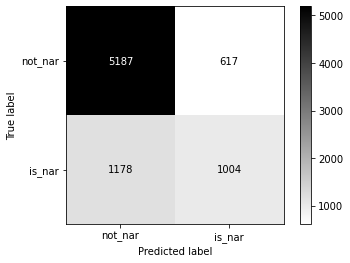

In [84]:
best_crf = rs_scaled.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),best_crf.classes_)